# Notebook for Edge et al. (2022) JGR:JAMES submission

## Case Study 3: Erosion model 1

Notes:
- This version of the notebook was not run in an optimized Python environment (g++, chain parallelization). 


In [1]:
import os
import glob
import numpy as np
import xarray as xr
import pandas as pd
import arviz as az
import seaborn as sns
import pymc3 as pm
import theano.tensor as tt
import matplotlib.pyplot as plt
import cmocean as cmoc
from matplotlib import cm
import matplotlib as mpl
from scipy.interpolate import RectBivariateSpline
from scipy.signal import butter, sosfiltfilt

from edge_funcs import *

%matplotlib inline

sns.set()
sns.set_style("white")
sns.set_style("ticks")

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Load the forcing and fitting data


In [2]:
ds = xr.load_dataset('CS3_data.nc')

### Create the grid and interpolate forcing / fitting data

In [3]:
del_z = 1.0
del_t = 300.0
h_tot = 24.0

km_bg = 10**-4

In [4]:
fg, mg, tg = generate_grid(h_tot, del_z, (len(ds.tg)-3)*60, del_t) 
print('Grid size = ', str(len(mg)), ' x ', str(len(tg)))

Grid size =  24  x  452


In [5]:
# Interpolate data onto new tg
cur_fi = interp1d(ds.tg, ds.current)
cur_it = cur_fi(tg)

wp_fi = RectBivariateSpline(ds.tg, ds.fg, ds.w_all)
w_prof_all = wp_fi(tg, fg)

ssc_fi = RectBivariateSpline(ds.tg, ds.mg, ds.c_all)
ssc_it = ssc_fi(tg, mg)

bbl_nan = np.isnan(ds.bbl_db)
bbl_fi = interp1d(ds.tg[~bbl_nan], ds.bbl_db[~bbl_nan], bounds_error=False)
bbl_it = bbl_fi(tg)

obs_htx = ((mg >= 1.0) & (mg <= 2.0)) | ((mg >= 9.0) & (mg <= 10.0))
obs_meas = ssc_it[:,obs_htx]

In [6]:
u_bed = np.sqrt(cur_it**2 * 0.00185)
t_bed = 1035*u_bed**2

Ks_all = calc_Ks(u_bed, fg, bbl_it, km_bg)
# Ks_cub[Ks_cub<km_bg] = km_bg

c_init = ssc_it[0,:]

In [7]:
# Lowpass filter the vertical velocities
sos = butter(2, 1/(6*3600), btype='lowpass', output='sos', fs=1/300)
w_all_lp = np.full_like(w_prof_all, np.nan)
for ix, wa in enumerate(w_all_lp.T):
    w_all_lp[:,ix] = sosfiltfilt(sos, wa)

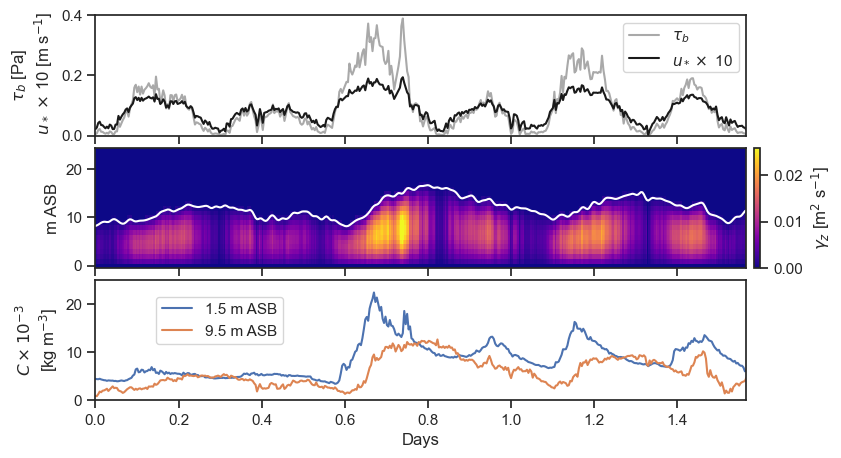

In [8]:
fig, ax = plt.subplots(3, 1, figsize=(10,5))
plt.subplots_adjust(hspace=0.1)

ax1plt, = ax[0].plot(tg/60/60/24, t_bed, label='$\\tau_b$', c='darkgrey')
ax[0].plot(tg/60/60/24, 10*u_bed, label=r'$u_* \times$ 10', c='k')

ax[0].set_ylabel('$\\tau_b$ [Pa]\n $u_*$ $\\times$ 10 [m s$^{-1}$]')
ax[0].legend()
ax[0].set_ylim(0, 0.5)
ax[0].set_ylim(0, 0.4)

pc=ax[1].pcolor(tg/60/60/24, fg, Ks_all.T, cmap=cm.plasma, vmin=0, vmax=0.026)
cb2 = fig.colorbar(pc, ax=ax[1], pad=0.01)
mpl.colorbar.ColorbarBase.set_label(cb2, '$\gamma_z$ [m$^2$ s$^{-1}$]')
ax[1].set_ylabel('m ASB')
ax[1].plot(tg/60/60/24, bbl_it, c='w')

ax[2].plot(tg/60/60/24, 1000*obs_meas[:,0], label=('1.5 m ASB'))
ax[2].plot(tg/60/60/24, 1000*obs_meas[:,1], label=('9.5 m ASB'))

ax[2].legend(bbox_to_anchor=(0.3, 0.4))

ax[2].set_ylabel('$C \\times 10^{-3}$\n[kg m$^{-3}$]')
ax[2].set_xlabel('Days')
ax[2].set_ylim(0, 25)

ax_zero = ax[1].get_position().bounds
for x in ax:
    x.set_xlim(0, tg[-1]/60/60/24)
    if x != ax[-1]:
        x.set_xlabel('')
        x.set_xticklabels('')

    if (x == ax[0]) | (x == ax[2]):
        ax_one = x.get_position().bounds
        x.set_position([ax_zero[0], ax_one[1], ax_zero[2], ax_one[3]])


# Run the inference

See edge_funcs.py for numerical model code, log-likelihood function, and related functions

In [9]:
model_spec = [tg, mg, fg, c_init, Ks_all, h_tot, t_bed]

In [10]:
# create operation
logl = LogLike(my_loglike, ssc_it, 'E1', model_spec, obs_htx, True)

# create model and set priors
with pm.Model() as model:
    w_s_pdf = pm.Lognormal('w_s', mu=0.5, sigma=0.7)
    e_0_pdf = pm.HalfNormal('e_0', sd=20)
    t_c_pdf = pm.HalfNormal('t_c', sd=3)
    m_c_pdf = 0.0
    b_c_pdf = pm.Lognormal('b_c', mu=0.25, sigma=0.5)
    sig_pdf = pm.HalfNormal('sig_mod', 0.3)

    # Convert parameters to a tensor vector
    theta = tt.as_tensor_variable([w_s_pdf, e_0_pdf, t_c_pdf, m_c_pdf, b_c_pdf, sig_pdf])
    
    # Specify custom log-likelihood (standard Guassian that takes numerical model output - see edge_funcs.py)
    likelihood = pm.DensityDist("likelihood", lambda v: logl(v), observed={"v": theta})
    
#     # Save log-likelihood value (extra step - increases run time)
#     llk = pm.Deterministic('logp', model.logpt)

In [11]:
# with model:
#     trace_norm = pm.sample(20000, step=pm.DEMetropolis(), chains=12, tune=10000,\
#                            pickle_backend='dill', cores=1, compute_convergence_checks=False)

In [12]:
# with model:
#     id_all = az.from_pymc3(trace_norm, density_dist_obs=False, log_likelihood=False)
# i_xr = az.convert_to_dataset(id_all)
# i_xr_result = i_xr.isel(draw=np.arange(10000,30000)))
# i_xr_result.to_netcdf(path='CS3_E1', mode='w')
# print('Trace saved')

i_xr_result = xr.open_dataset('CS3_E1', engine='netcdf4', mode='r')
print('Trace loaded') 

Trace loaded


# Plot the trace

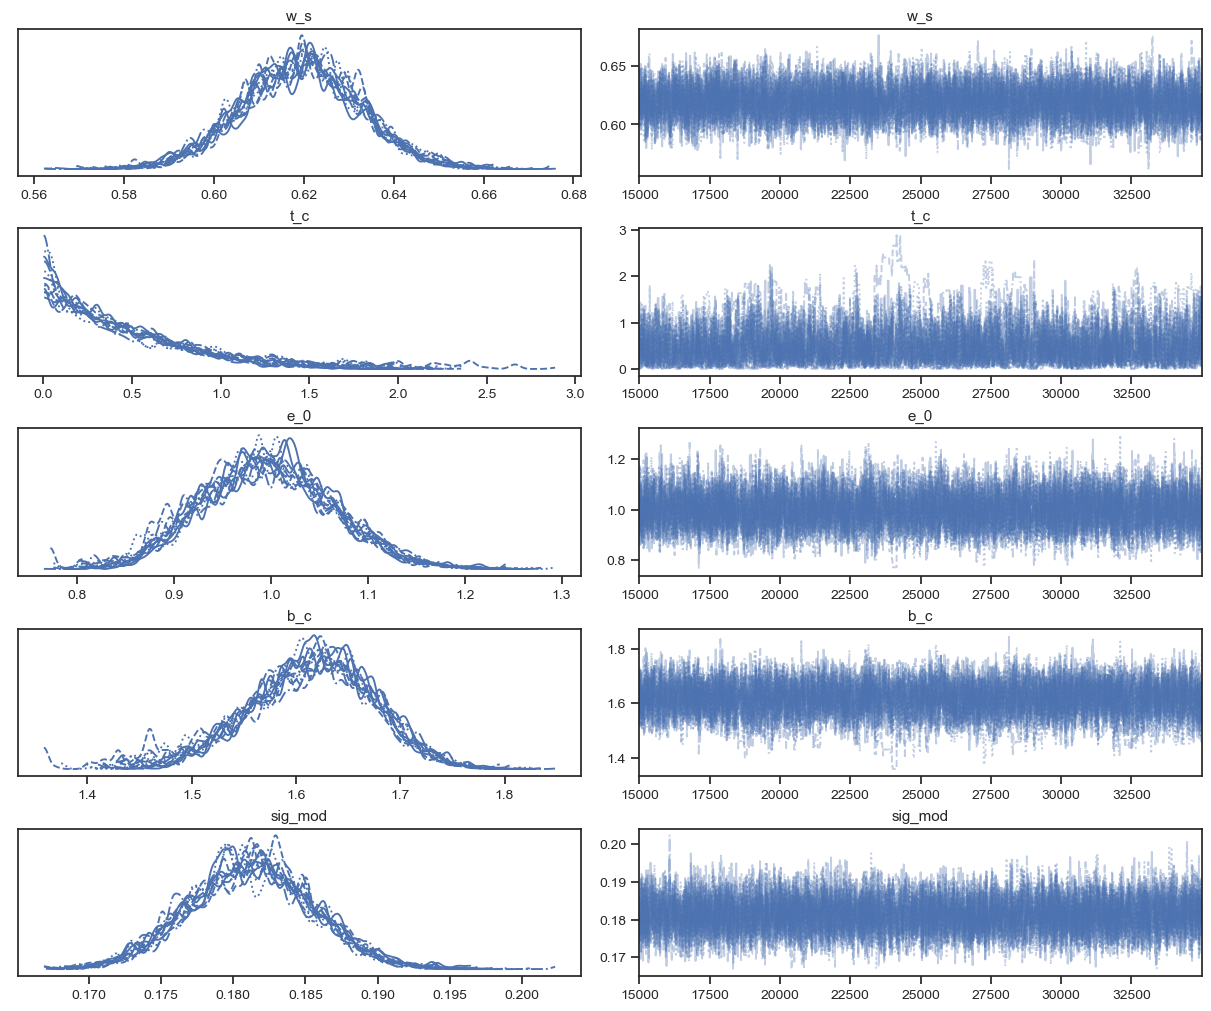

In [13]:
_=az.plot_trace(i_xr_result)

In [14]:
az.stats.summary(i_xr_result)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
w_s,0.619,0.013,0.594,0.644,0.000,0.000,5298.0,7716.0,1.00
t_c,0.488,0.436,0.000,1.305,0.014,0.013,1301.0,833.0,1.01
e_0,0.995,0.069,0.871,1.122,0.001,0.001,3352.0,3169.0,1.01
b_c,1.613,0.062,1.494,1.726,0.002,0.001,1901.0,1105.0,1.01
sig_mod,0.181,0.004,0.173,0.189,0.000,0.000,5555.0,9149.0,1.00


In [15]:
df = i_xr_result.to_dataframe()
df.reset_index(drop=True, inplace=True)

# Force correct order
dcols = ['w_s', 'e_0', 't_c', 'b_c', 'sig_mod']
df = df[dcols]

In [16]:
w_s_prior = w_s_pdf.random(size=len(df))
t_c_prior = t_c_pdf.random(size=len(df))
e_0_prior = e_0_pdf.random(size=len(df))
b_c_prior = b_c_pdf.random(size=len(df))
sig_prior = sig_pdf.random(size=len(df))

df_prior = pd.DataFrame({'w_s':w_s_prior, 'e_0':e_0_prior, 't_c':t_c_prior, 'b_c':b_c_prior, 'sig_mod':sig_prior})

(1.62, 1.99)

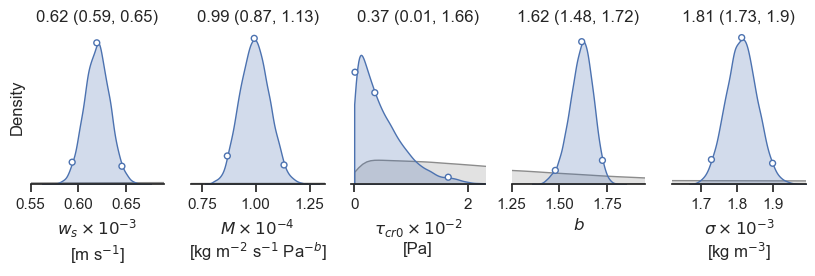

In [17]:
fig, ax = plt.subplots(1, 5, figsize=(10,2), constrained_layout=False)

labs = ['$w_s \\times 10^{-3}$\n[m s$^{-1}$]', '$M \\times 10^{-4}$\n[kg m$^{-2}$ s$^{-1}$ Pa$^{-b}$]',\
        '$\\tau_{cr0} \\times 10^{-2}$\n[Pa]', r'$b$', '$\\sigma \\times 10^{-3}$\n[kg m$^{-3}$]']
plt_scaling = [1,1,1,1,10]

for (x, dpri, dpos, lbs, ps) in zip(ax, df_prior, df, labs, plt_scaling):
    df_p = df_prior[dpri]*ps
    df_s = df[dpos]*ps
    sns.kdeplot(df_p, ax=x, fill=True,\
                color=sns.color_palette("deep", 10)[7], cut=0)
    sns.kdeplot(df_s, ax=x, fill=True, bw_adjust=2.0,\
                color=sns.color_palette("deep", 10)[0], cut=0)
    
    ldt = sns.kdeplot(df_s, alpha=0, ax=x,\
                        cut=0).get_lines()[0].get_data()
        
    ax_med = np.median(df_s)
    ax_025 = np.percentile(df_s, 2.5)
    ax_975 = np.percentile(df_s, 97.5)
    
    ax_med_ix = np.argmin(np.abs(ax_med - ldt[0]))
    ax_025_ix = np.argmin(np.abs(ax_025 - ldt[0]))
    ax_975_ix = np.argmin(np.abs(ax_975 - ldt[0]))
    ax_plt = [ax_025_ix, ax_med_ix, ax_975_ix]
    
    sns.scatterplot(x=ldt[0][ax_plt], y=ldt[1][ax_plt], ax=x,\
                    facecolor='w',\
                    edgecolor=sns.color_palette("deep", 10)[0],\
                    size=8, linewidth=1, legend=False, zorder=4)

    x.set_xlabel(lbs)
    
    x.set_title(str(np.round(ax_med, 2)) + ' (' + str(np.round(ax_025, 2)) + ', ' +\
                str(np.round(ax_975, 2)) + ')')
    
    x.spines['right'].set_visible(False)
    x.spines['left'].set_visible(False)
    x.spines['top'].set_visible(False)

    x.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
    if x != ax[0]:
        x.set_ylabel('')
ax[0].set_xlim(0.55,0.69)
ax[1].set_xlim(0.70,1.32)
ax[2].set_xlim(-0.05,2.3)
ax[3].set_xlim(1.25,1.95)
ax[4].set_xlim(1.62,1.99)


Text(0, 0.5, '$b$')

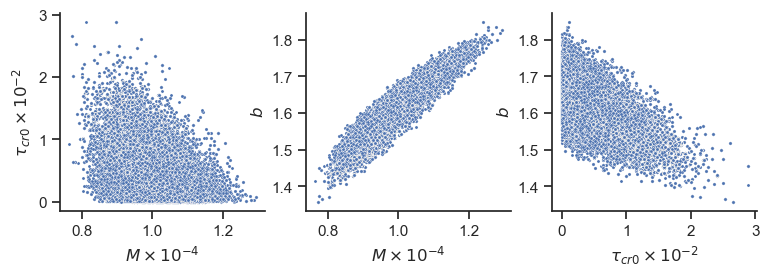

In [18]:
fig, ax = plt.subplots(1, 3, figsize=(9,9/3.5), constrained_layout=False)

sns.scatterplot(x=df['e_0'], y=df['t_c'], ax=ax[0], s=5)
sns.scatterplot(x=df['e_0'], y=df['b_c'], ax=ax[1], s=5)
sns.scatterplot(x=df['t_c'], y=df['b_c'], ax=ax[2], s=5)

# Slow
# sns.kdeplot(df['e_0'], df['t_c'], ax=ax[0], levels=[0.05, 0.2 ,0.5], color='k', cut=0, bw_adjust=1.5)
# sns.kdeplot(df['e_0'], df['b_c'], ax=ax[1], levels=[0.05, 0.2 ,0.5], color='k', cut=0, bw_adjust=1.5)
# sns.kdeplot(df['t_c'], df['b_c'], ax=ax[2], levels=[0.05, 0.2 ,0.5], color='k', cut=0, bw_adjust=1.5)

for x in ax:
    x.spines['right'].set_visible(False)
    x.spines['top'].set_visible(False)
    
ax[0].set_ylabel(r'$\tau_{cr0} \times 10^{-2}$')
ax[0].set_xlabel('$M \\times 10^{-4}$')

ax[2].set_ylabel('$b$')
ax[2].set_xlabel(r'$\tau_{cr0} \times 10^{-2}$')

ax[1].set_xlabel('$M \\times 10^{-4}$')
ax[1].set_ylabel('$b$')


# Sample the model posterior

In [19]:
n_samp = 1000 # 10,000 for paper
trace_len = len(df)
rand_init = np.random.randint(0, trace_len, (n_samp))
samp_res = np.full((n_samp, len(tg), len(mg)), np.nan)
samp_noi = np.full((n_samp, len(tg), len(mg)), np.nan)

for ix, ri in enumerate(rand_init):
    theta_pred = [df['w_s'][ri], df['e_0'][ri], df['t_c'][ri], 0.0, df['b_c'][ri]]
    samp_res[ix,:,:] = obj(theta_pred, 'E1', model_spec, True)
    
    # Scale sigma same as log-likelihood (/100)
    samp_noi[ix,:,:] = np.random.normal(loc=0, \
                                      scale=df['sig_mod'][ri]/100,\
                                      size=(len(tg),len(mg)))

In [20]:
noi_CI16 = np.percentile((samp_res + samp_noi)[:,:,1], 25, axis=0)
noi_CI84 = np.percentile((samp_res + samp_noi)[:,:,1], 75, axis=0)

noi_CI05 = np.percentile((samp_res + samp_noi)[:,:,1], 10, axis=0)
noi_CI95 = np.percentile((samp_res + samp_noi)[:,:,1], 90, axis=0)

noi_CI01 = np.percentile((samp_res + samp_noi)[:,:,1], 2.5, axis=0)
noi_CI99 = np.percentile((samp_res + samp_noi)[:,:,1], 97.5, axis=0)

hih_CI16 = np.percentile((samp_res + samp_noi)[:,:,9], 25, axis=0)
hih_CI84 = np.percentile((samp_res + samp_noi)[:,:,9], 75, axis=0)

hih_CI05 = np.percentile((samp_res + samp_noi)[:,:,9], 10, axis=0)
hih_CI95 = np.percentile((samp_res + samp_noi)[:,:,9], 90, axis=0)

hih_CI01 = np.percentile((samp_res + samp_noi)[:,:,9], 2.5, axis=0)
hih_CI99 = np.percentile((samp_res + samp_noi)[:,:,9], 97.5, axis=0)

C:\Users\00099894\AppData\Local\Temp\ipykernel_17464\2004287126.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels([''])


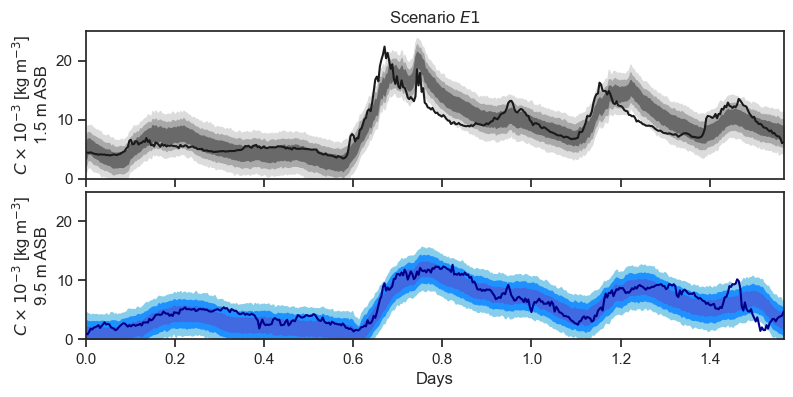

In [21]:
fig, ax = plt.subplots(2,1, figsize=(9,4.0), constrained_layout=False)

lowplt = ax[1].fill_between(tg/60/60/24, hih_CI16*1000,\
                 y2=hih_CI84*1000, color='royalblue', label='9.5 m ASB', zorder=2)
ax[1].fill_between(tg/60/60/24, hih_CI05*1000,\
                 y2=hih_CI95*1000, color='dodgerblue', zorder=1)
ax[1].fill_between(tg/60/60/24, hih_CI01*1000,\
                 y2=hih_CI99*1000, color='skyblue', zorder=0)
ax[1].plot(tg/60/60/24, 1000*obs_meas[:,1], zorder=4, c='darkblue')

hihplt = ax[0].fill_between(tg/60/60/24, noi_CI16*1000,\
                 y2=noi_CI84*1000, color='dimgrey', label='1.5 m ASB', zorder=2)
ax[0].fill_between(tg/60/60/24, noi_CI05*1000,\
                 y2=noi_CI95*1000, color='darkgrey', zorder=1)
ax[0].fill_between(tg/60/60/24, noi_CI01*1000,\
                 y2=noi_CI99*1000, color='gainsboro', zorder=0)
ax[0].plot(tg/60/60/24, 1000*obs_meas[:,0], c='k', zorder=4)

ax[0].set_title('Scenario $E1$')
ax[0].set_ylabel('$C \\times 10^{-3}$ [kg m$^{-3}$]\n1.5 m ASB')
ax[0].set_xlabel('')
ax[0].set_xticklabels([''])
ax[0].set_xlim((tg/60/60/24)[0], (tg/60/60/24)[-1])
ax[0].set_ylim(0, 25)

ax[1].set_ylabel('$C \\times 10^{-3}$ [kg m$^{-3}$]\n9.5 m ASB')
ax[1].set_xlabel('Days')
ax[1].set_xlim((tg/60/60/24)[0], (tg/60/60/24)[-1])
ax[1].set_ylim(0, 25)
plt.subplots_adjust(hspace=0.09)

In [22]:
!jupyter nbconvert --to html CaseStudy3_E1_DE-MC.ipynb

[NbConvertApp] Converting notebook CaseStudy3_E1_DE-MC.ipynb to html
[NbConvertApp] Writing 1816889 bytes to CaseStudy3_E1_DE-MC.html
